# Money in the Huggett economy

**Table of contents**<a id='toc0_'></a> 
- 1. [Solve the Simple Huggett economy](#toc1_)
	- 1.1. [Parameters](#toc1_1_)
	- 1.2. [Income State Space](#toc1_2_)
	- 1.3. [Creating the Grid for Asset choice](#toc1_3_)
	- 1.4. [Visualizing the Individual State Space](#toc1_4_)
	- 1.5. [Bellman Equation](#toc1_5_)
	- 1.6. [Numerical Solution Implementation](#toc1_6_)
	- 1.7. [Value Function: Solution](#toc1_7_)
	- 1.8. [Policy (For asset) Function: Solution](#toc1_8_)
	- 1.9. [Interest rate: Solution](#toc1_9_)
	- 1.10. [Cumulative Distribution of aggregate state](#toc1_10_)
	- 1.11. [Consumption Policy Function: Solution](#toc1_11_)
	
- 2. [Introducing money into the Huggett economy](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config

## Note:

For this code, I use two libraries programmed by myself. First, Toolkit.py which has all the functions needed in the 
simulation. Second, tauchenhussey.py which is the implementation of tauchenhussey idea of finding the transition matrix
and state space of an $AR(1)$ process.

## 1. <a id='toc1_'></a>[Solve the Simple Hugget Economy](#toc1_)

**$AR(1)$ Income Process**: Defined as follows:
$$
\begin{gather}
s_{t+1} = \rho s_t + \epsilon_{t+1} \quad \quad y_t = \exp(s_t) \quad \quad
\epsilon_t \equiv \mathcal{N}\left(0, \sigma_\epsilon^2\right)
\end{gather}
$$

In [1]:
import tauchenhussey as th
import Toolkit as tk
import numpy as np
import math as m
import numba
import matplotlib.pyplot as plt

## 1.1. <a id='toc1_1_'></a>[Parameters](#toc1_1_)

In [2]:
########## Model Parameters ##########
beta = 0.993362 ## 2-monthly discount factor
gamma = 3.0 ## risk aversion
a_under = -3.0 ## lower bound of the grid for assets
a_bar = 24.0 ## upper bound of the grid for assets
A_bar = 0 ## Bond net supply
#######################################

########## Income Process Parameters ##########
N = 3 ## number of states for the income process
rho = 0.95 ## persistence of the income process
mu = 0.0 ## mean of the income process
sigma_eps = 0.015 ## standard deviation of the income process
#######################################

########## Discritization Parameters ##########
M = 1000 ## number of grid points for assets
N = 3 ## number of grid points for income
#######################################

########## Convergence Parameters ##########
epsilon_v = 10**(-6) ## tolerance for the value function iteration
epsilon_d = 10**(-8) ## tolerance for the distribution iteration
epsilon_m = 10**(-3) ## tolerance for the market clearing
max_iter_v = 1000 ## maximum number of iterations
max_iter_d = 100 ## maximum number of iterations
max_iter_m = 100 ## maximum number of iterations
#######################################

## 1.2. <a id='toc1_2_'></a>[Income State Space](#toc1_2_)

Here, $S$ is the space of the state $s$ and $Sprob$ is the transition matrix of this markov process

In [3]:
sigmaS = sigma_eps/np.sqrt(1-rho**2) ## std. dev. of the stationary s_t process
w = 0.5 + rho/4
baseSigma = w*sigma_eps +(1-w)*sigmaS ## std. dev. used to calculate Gaussian quadrature weights and nodes
[S, Sprob] = th.tauchenhussey(N,mu,rho,sigma_eps,baseSigma)
Y = np.exp(S)[0] ## income grids
print("Income grid: ", Y)

Income grid:  [0.95982708 1.         1.04185433]


Therefore, the Y space is as follows:
$$
\begin{gather}
y\in Y = \{0.9598, 1, 1.0418\}
\end{gather}
$$

## 1.3. <a id='toc1_3_'></a>[Creating the Grid for Asset choice](#toc1_3_)

For the grid of the asset space, we may use a double exponential or a single
exponential transportation of a linspace grid

$$
\begin{gather}
\text{Double Exponential} \quad a_i = \underline{a} + e^{e^{u_i - 1}} - 1 \quad u_i \in [0, \bar{u}] \\
\text{Single Exponential} \quad a_i = \underline{a} + e^{{u_i - 1}} - 1 \quad u_i \in [1, \bar{u}]
\end{gather}


In [22]:
A = tk.grid_asset_double_exp(a_under,a_bar,M) ## grid for assets
#A = tk.grid_asset_exp(a_under,a_bar,M) ## grid for assets

## 1.4. <a id='toc1_4_'></a>[Visualizing the Individual State Space](#toc1_4_)

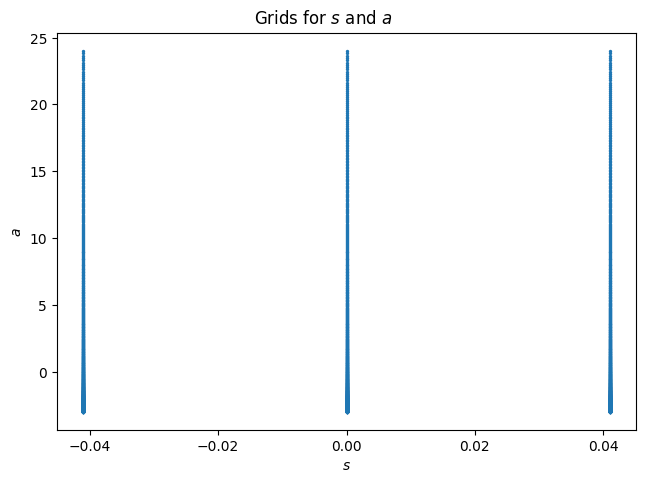

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

s_grid,a_grid = np.meshgrid(S,A,indexing='ij')
ax.scatter(s_grid,a_grid,2)

ax.set_yscale('linear')
ax.set_xlabel('$s$')
ax.set_ylabel('$a$')

fig.suptitle('Grids for $s$ and $a$')
fig.tight_layout(pad=0.5)

## 1.5. <a id='toc1_5_'></a>[Bellman Equation](#toc1_5_)

The Value function of the Household is defined as follows:

$$
\begin{gather}
V(a,s) = \max_{c,a'} \{u(c) + \beta \sum_{s'=1}^S P(s,s') V(a',s')\}
\\
\text{s.t.} c+a' = a(1+r) + y(s)\\
a'\geq \underline{a}
\end{gather}

## 1.6. <a id='toc1_6_'></a>[Numerical Solution Implementation](#toc1_6_)

In the following box, the full implementation of finding the solution numericaly is presented.

In [25]:
Value_init = np.zeros((M,N)) ## value function
dist = np.full((M,N), 1/(M*N)) ## Aggregate distribution

counter =  0
r_min = -1.0 ## lower bound for the interest rate
r_max = 1/beta - 1 ## upper bound for the interest rate
r = np.average([r_min,r_max]) ## initial guess for the interest rate
diff = 1 ## difference between the demand and supply of bonds


############### Iteration to find the interest rate that clears the market
while counter < max_iter_m and np.abs(diff) > epsilon_m:
    r_old = r
    counter += 1
    
    #### Value Function Iteration
    [Value, Policy_index, Policy, Utility] = tk.VFI(A, Y, Sprob, gamma, beta, r, Value_init, epsilon_v, max_iter_v)
    
    #### Distribution Iteration
    distribution = tk.Distribution_iteration(A,Y,Policy_index,Sprob,epsilon_d, max_iter_d)
    
    demand = tk.Aggregation(distribution,Policy)
    diff = demand - A_bar
    print("Iteration: ", counter, "Interest rate: ", r)
    if np.abs(diff) > epsilon_m:
        if demand > A_bar:
            r_max = r
        elif demand < A_bar:
            r_min = r
    else:
        break
    r = np.average([r_min,r_max])
    r_change = np.abs(r - r_old)
    if r_change < 0.00001:
        break
##########################################################################################

Iteration:  1 Interest rate:  -0.496658821255494
Iteration:  2 Interest rate:  -0.24498823188324098
Iteration:  3 Interest rate:  -0.11915293719711448
Iteration:  4 Interest rate:  -0.056235289854051226
Iteration:  5 Interest rate:  -0.0247764661825196
Iteration:  6 Interest rate:  -0.009047054346753788
Iteration:  7 Interest rate:  -0.0011823484288708812
Iteration:  8 Interest rate:  0.002750004530070572
Iteration:  9 Interest rate:  0.004716181009541298
Iteration:  10 Interest rate:  0.005699269249276662
Iteration:  11 Interest rate:  0.0061908133691443434
Iteration:  12 Interest rate:  0.0059450413092105026
Iteration:  13 Interest rate:  0.005822155279243582
Iteration:  14 Interest rate:  0.005760712264260122
Iteration:  15 Interest rate:  0.005791433771751852
Iteration:  16 Interest rate:  0.005806794525497717


#### Checking the market clearing condition

In [26]:
print("Demand for bonds is equal to: ", demand)

Demand for bonds is equal to:  -0.02344469213778283


## 1.7. <a id='toc1_7_'></a>[Value Function: Solution](#toc1_7_)

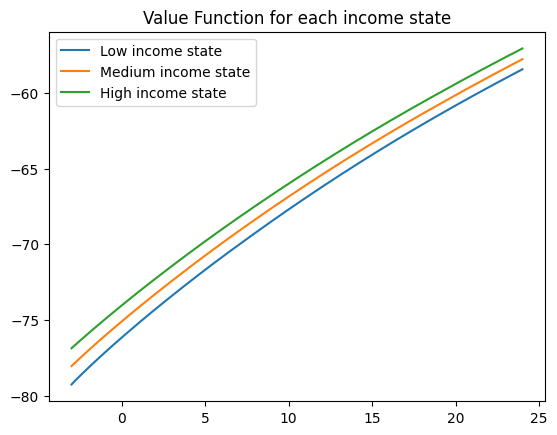

In [27]:
plt.plot(A,Value[:,0], label='Low income state')
plt.plot(A,Value[:,1], label='Medium income state')
plt.plot(A,Value[:,2], label='High income state')
plt.legend()
plt.title('Value Function for each income state')
plt.show()

## 1.8. <a id='toc1_8_'></a>[Policy (For asset) Function: Solution](#toc1_8_)

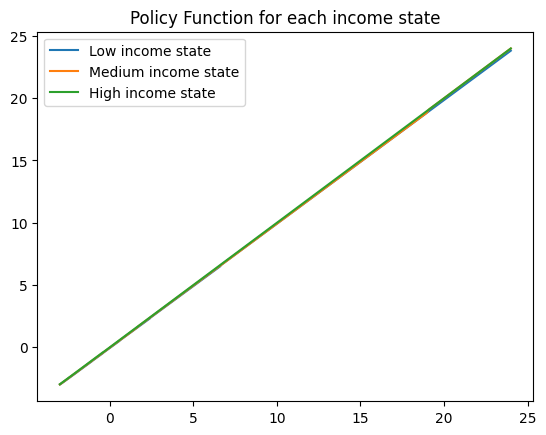

In [28]:
plt.plot(A,Policy[:,0], label='Low income state')
plt.plot(A,Policy[:,1], label='Medium income state')
plt.plot(A,Policy[:,2], label='High income state') 
plt.legend()
plt.title('Policy Function for each income state')
plt.show()

## 1.9. <a id='toc1_9_'></a>[Interest rate: Solution](#toc1_9_)

In [29]:
r_simpleHugget = r
print("The Interese rate is equal to: " , r)

The Interese rate is equal to:  0.00581447490237065


## 1.10. <a id='toc1_10_'></a>[Cumulative Distribution of aggregate state](#toc1_10_)

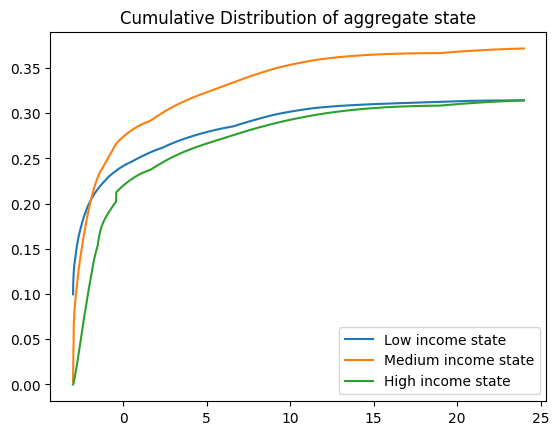

In [30]:
plt.plot(A,np.cumsum(distribution[:,0]), label='Low income state')
plt.plot(A,np.cumsum(distribution[:,1]), label='Medium income state')
plt.plot(A,np.cumsum(distribution[:,2]), label='High income state')
plt.legend()
plt.title('Cumulative Distribution of aggregate state')
plt.show()

## 1.11. <a id='toc1_11_'></a>[Consumption Policy Function: Solution](#toc1_11_)

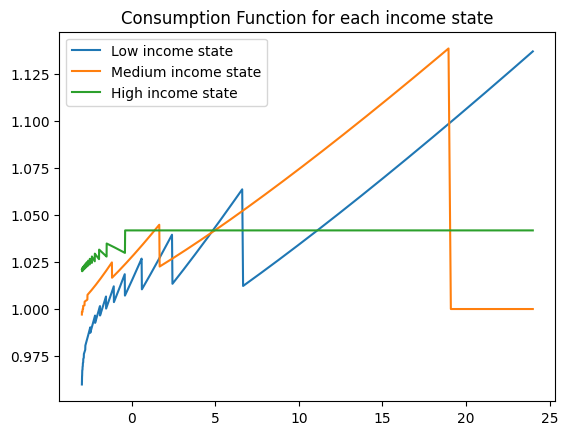

In [31]:
cons = np.zeros((M,N))
for i in range(M):
    for j in range(N):
        cons[i,j] = A[i] + Y[j] - Policy[i,j]

plt.plot(A,cons[:,0], label='Low income state')
plt.plot(A,cons[:,1], label='Medium income state')
plt.plot(A,cons[:,2], label='High income state') 
plt.legend()
plt.title('Consumption Function for each income state')
plt.show()

## 2. <a id='toc2_'></a>[Introducing money into the Huggett economy](#toc2_)

As adding the money will increase the level of interest rate, we can start the iteration from the previous level of interest. Moreover, 
we should increase the maximum level of r in the grid.

In [38]:
A = tk.grid_asset_exp(a_under,a_bar,M) ## grid for assets

In [39]:
Value_init = np.zeros((M,N)) ## value function
dist = np.full((M,N), 1/(M*N)) ## Aggregate distribution
A_bar = 10 ## Bond net supply
counter =  0
r_min = r_simpleHugget ## lower bound for the interest rate
r_max = 10/beta ## upper bound for the interest rate
r = np.average([r_min,r_max]) ## initial guess for the interest rate
diff = 1 ## difference between the demand and supply of bonds

############### Iteration to find the interest rate that clears the market
while counter < max_iter_m and np.abs(diff) > epsilon_m:
    r_old = r
    counter += 1
    
    #### Value Function Iteration
    [Value_money, Policy_index_money, Policy_money, Utility_money] = tk.VFI(A, Y, Sprob, gamma, beta, r, Value_init, epsilon_v, max_iter_v)
    
    #### Distribution Iteration
    distribution = tk.Distribution_iteration(A,Y,Policy_index_money,Sprob,epsilon_d,max_iter_d)
    
    demand = tk.Aggregation(distribution,Policy_money)
    diff = demand - A_bar
    print("Iteration: ", counter, "Interest rate: ", r, "Demand: ", demand, "Difference: ", diff)
    if np.abs(diff) > epsilon_m:
        if demand > A_bar:
            r_max = r
        elif demand < A_bar:
            r_min = r
    else:
        break
    r = np.average([r_min,r_max])
    change_r = np.abs(r - r_old)
    
    if change_r < 0.00001:
        break
##########################################################################################

Iteration:  1 Interest rate:  5.036319024896246 Demand:  11.443550223315796 Difference:  1.4435502233157962
Iteration:  2 Interest rate:  2.5210667498993082 Demand:  3.754770278240805 Difference:  -6.245229721759195
Iteration:  3 Interest rate:  3.778692887397777 Demand:  10.206197537653505 Difference:  0.20619753765350524
Iteration:  4 Interest rate:  3.1498798186485426 Demand:  8.600234336819149 Difference:  -1.399765663180851
Iteration:  5 Interest rate:  3.4642863530231596 Demand:  9.564033314175756 Difference:  -0.43596668582424414
Iteration:  6 Interest rate:  3.6214896202104683 Demand:  9.909621013709028 Difference:  -0.09037898629097185
Iteration:  7 Interest rate:  3.7000912538041226 Demand:  10.070555645743973 Difference:  0.07055564574397266
Iteration:  8 Interest rate:  3.6607904370072957 Demand:  9.990484572699868 Difference:  -0.009515427300131662
Iteration:  9 Interest rate:  3.680440845405709 Demand:  10.017619824788694 Difference:  0.01761982478869406
Iteration:  10 In

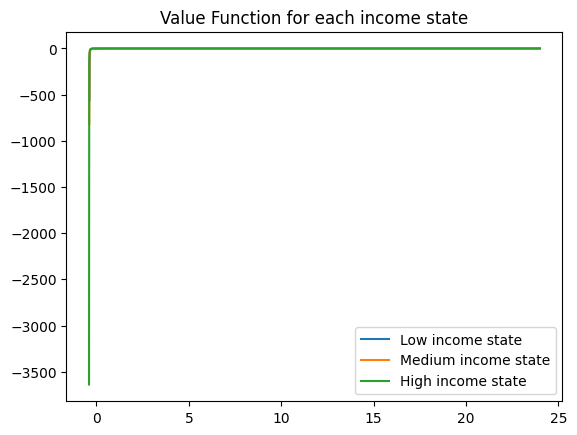

In [42]:
plt.plot(A,Value_money[:,0], label='Low income state')
plt.plot(A,Value_money[:,1], label='Medium income state')
plt.plot(A,Value_money[:,2], label='High income state')
plt.legend()
plt.title('Value Function for each income state')
plt.show()

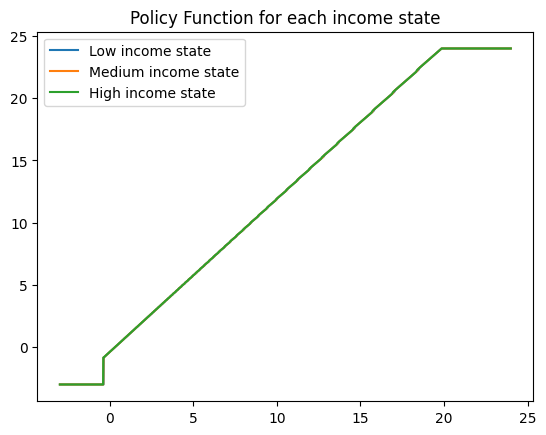

In [44]:
plt.plot(A,Policy_money[:,0], label='Low income state')
plt.plot(A,Policy_money[:,1], label='Medium income state')
plt.plot(A,Policy_money[:,2], label='High income state') 
plt.legend()
plt.title('Policy Function for each income state')
plt.show()

In [45]:
r_money = r
print("The Interese rate is equal to: " , r)

The Interese rate is equal to:  3.670068730425882


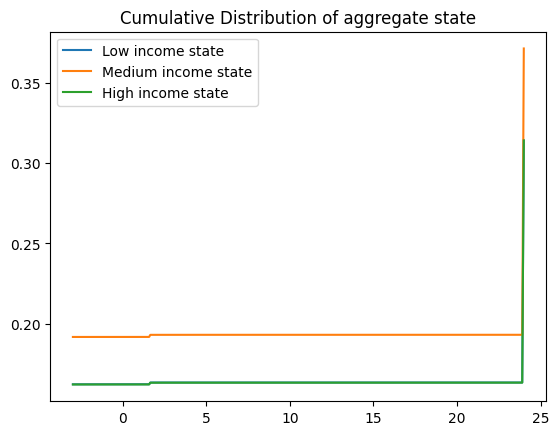

In [46]:
plt.plot(A,np.cumsum(distribution[:,0]), label='Low income state')
plt.plot(A,np.cumsum(distribution[:,1]), label='Medium income state')
plt.plot(A,np.cumsum(distribution[:,2]), label='High income state')
plt.legend()
plt.title('Cumulative Distribution of aggregate state')
plt.show()